In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.3'

We can check which devices are avaliable using with keras.

In [78]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

We'll download a pretrain model without the top, meaning without the fully connected layers. We'll use the bottom half of the model as a feature extractor and retrain our own fully connected layer for classication.

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [80]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

When working with lagre datasets like lots of images we, don't want to load them all into memory at once. We can use generators to load the images in batches. For the keras `ImageDataGenerator` our data directory has to be in a particular structure, see [here](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) for details .

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [4]:
path = '.../data/cat_dog_test_set'
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1000

In [10]:
%%bash
#tree -d /home/dom/datasets/dog-vs-cat/train
tree -d /data/cat_dog_test_set

bash: line 2: tree: command not found


In [ ]:
datagen.flow_from_directory

The folder names inside the train folder will be used as labels.

In [84]:

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        #We use the conv_base to extract the images features
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


In [ ]:
n_samples = 2000

In [95]:
features.shape

(20000, 8192)

In [96]:
labels.shape

(20000,)

In [87]:
features, labels = extract_features(train_dir,n_samples )

Found 25000 images belonging to 2 classes.


In [90]:
features = np.reshape(features, (n_samples, 4 * 4 * 512))#flatten lay output

In [97]:
from keras import models
from keras import layers
from keras import optimizers

In [98]:
#Here we'll retrain a classifier.
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])



In [100]:
history = model.fit(features, labels,
                    epochs=200,
                    batch_size=1024,
                    validation_split=0.2 )

Train on 16000 samples, validate on 4000 samples
Epoch 1/200
16000/16000 [==============================] - 1s 81us/step - loss: 0.6752 - acc: 0.6068 - val_loss: 0.5173 - val_acc: 0.7862
Epoch 2/200
16000/16000 [==============================] - 1s 60us/step - loss: 0.5247 - acc: 0.7415 - val_loss: 0.4290 - val_acc: 0.8327
Epoch 3/200
16000/16000 [==============================] - 1s 61us/step - loss: 0.4468 - acc: 0.7954 - val_loss: 0.3781 - val_acc: 0.8483
Epoch 4/200
16000/16000 [==============================] - 1s 65us/step - loss: 0.3919 - acc: 0.8286 - val_loss: 0.3463 - val_acc: 0.8545
Epoch 5/200
16000/16000 [==============================] - 1s 61us/step - loss: 0.3654 - acc: 0.8374 - val_loss: 0.3175 - val_acc: 0.8710
Epoch 6/200
16000/16000 [==============================] - 1s 61us/step - loss: 0.3368 - acc: 0.8524 - val_loss: 0.3033 - val_acc: 0.8793
Epoch 7/200
16000/16000 [==============================] - 1s 60us/step - loss: 0.3228 - acc: 0.8621 - val_loss: 0.2890 - v

In [101]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [104]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [105]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

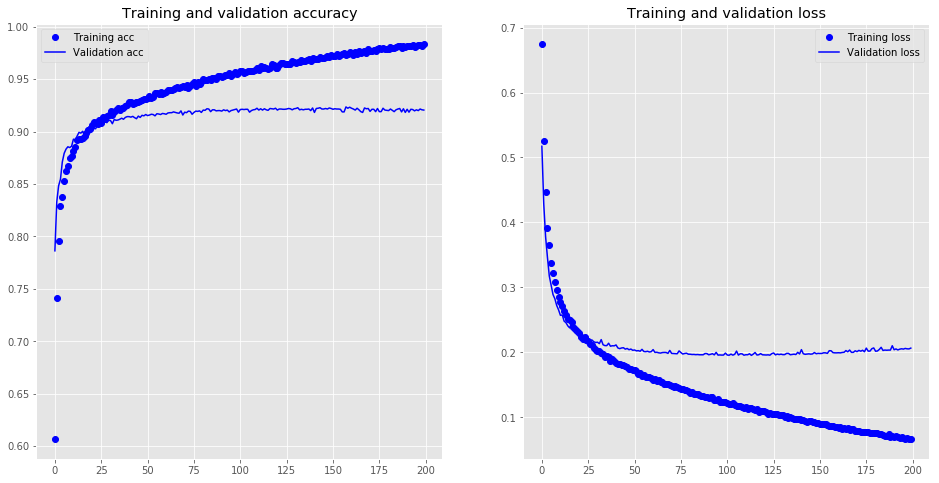

In [106]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()
